In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
def get_virtual_sources(source, room_width, room_height, max_order, reflection_coeffs_freq):
    # reflection_coeffs_freq = {
    #     'left': [r1, r2, r3, r4, r5, r6],  # для 6 частотных диапазонов
    #     'right': [r1, r2, r3, r4, r5, r6],
    #     'top': [r1, r2, r3, r4, r5, r6],
    #     'bottom': [r1, r2, r3, r4, r5, r6]
    # }
    # где r от 0 (полное поглощение) до 1 (полное отражение) для каждой частоты
    virtual_sources = []
    for n in range(-max_order, max_order + 1):
        for m in range(-max_order, max_order + 1):
            order = abs(n) + abs(m)
            if order == 0 or order > max_order:
                continue
            
            # Определяем количество отражений от каждой стены
            left_count = abs(n) if n < 0 else 0
            right_count = n if n > 0 else 0
            bottom_count = abs(m) if m < 0 else 0
            top_count = m if m > 0 else 0
            
            # Для каждого частотного диапазона вычисляем эффективный коэффициент
            effective_energy_factors = []
            for freq_idx in range(6):  # 6 частотных диапазонов
                factor = (
                    (reflection_coeffs_freq['left'][freq_idx] ** left_count) *
                    (reflection_coeffs_freq['right'][freq_idx] ** right_count) *
                    (reflection_coeffs_freq['bottom'][freq_idx] ** bottom_count) *
                    (reflection_coeffs_freq['top'][freq_idx] ** top_count)
                )
                effective_energy_factors.append(factor)
            
            if all(f == 0 for f in effective_energy_factors):
                continue  # Если энергия нулевая для всех частот, пропускаем
            
            # Вычисляем координаты виртуального источника
            x = n * room_width + (source[0] if n % 2 == 0 else room_width - source[0])
            y = m * room_height + (source[1] if m % 2 == 0 else room_height - source[1])
            virtual_sources.append({
                'pos': [x, y], 
                'order': order,
                'energy_factors': effective_energy_factors,  # 6 значений для 6 частот
                'left_refl': left_count,
                'right_refl': right_count,
                'top_refl': top_count,
                'bottom_refl': bottom_count
            })
    return virtual_sources


In [3]:
def find_wall_intersections(p1, p2, room_width, room_height):
    intersections = []
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]

    if dx != 0:
        t = (0 - p1[0]) / dx
        if 0 <= t <= 1:
            y = p1[1] + t * dy
            if 0 <= y <= room_height:
                intersections.append((0, y, 'left', t))
        t = (room_width - p1[0]) / dx
        if 0 <= t <= 1:
            y = p1[1] + t * dy
            if 0 <= y <= room_height:
                intersections.append((room_width, y, 'right', t))

    if dy != 0:
        t = (0 - p1[1]) / dy
        if 0 <= t <= 1:
            x = p1[0] + t * dx
            if 0 <= x <= room_width:
                intersections.append((x, 0, 'bottom', t))
        t = (room_height - p1[1]) / dy
        if 0 <= t <= 1:
            x = p1[0] + t * dx
            if 0 <= x <= room_width:
                intersections.append((x, room_height, 'top', t))

    return sorted(intersections, key=lambda inter: inter[3])



In [4]:
def plot_reflection_path(ax, points, color):
    xs, ys = zip(*points)
    ax.plot(xs, ys, linestyle='-', linewidth=1.5, color=color, alpha=0.7)
    # Не отмечаем начальную и конечную точки
    for p in points[1:-1]:
        ax.plot(p[0], p[1], 'bo', markersize=6, alpha=0.7)

In [5]:
# NEW: Функция для вычисления RT60
def calculate_rt60(times, energies, freq_label):
    """
    Рассчитывает RT60 (время реверберации) для заданных временных и энергетических данных
    """
    if len(energies) < 2:
        return None
    
    # Преобразуем энергию в уровень давления звука (в децибелах)
    # Уровень = 10 * log10(E/E0), где E0 - опорная энергия
    # Нормализуем энергию к относительным значениям
    energies = np.array(energies)
    # Убираем нули и отрицательные значения
    mask = energies > 0
    valid_times = np.array(times)[mask]
    valid_energies = energies[mask]
    
    if len(valid_energies) < 2:
        return None
    
    # Преобразуем энергию в уровень в децибелах
    levels_db = 10 * np.log10(valid_energies / np.max(valid_energies))
    
    # Сортируем по времени
    sorted_indices = np.argsort(valid_times)
    sorted_times = valid_times[sorted_indices]
    sorted_levels = levels_db[sorted_indices]
    
    # Проверяем, есть ли значительное падение уровня
    if sorted_levels[0] - sorted_levels[-1] < 5:  # Мало падения - не подходит для анализа
        return None
    
    # Ищем начальный участок для линейной регрессии
    # Обычно используется участок от -5 до -25 dB для более точного определения склона
    start_idx = 0
    end_idx = len(sorted_times) - 1
    
    # Пытаемся найти подходящий участок
    for i in range(len(sorted_levels)):
        if sorted_levels[i] <= -5:
            start_idx = i
            break
    
    for i in range(len(sorted_levels)-1, -1, -1):
        if sorted_levels[i] >= -25:
            end_idx = i
            break
    
    if end_idx <= start_idx:
        # Если не нашли подходящий участок, используем весь диапазон
        if len(sorted_times) >= 3:
            selected_times = sorted_times
            selected_levels = sorted_levels
        else:
            return None
    else:
        selected_times = sorted_times[start_idx:end_idx+1]
        selected_levels = sorted_levels[start_idx:end_idx+1]
    
    if len(selected_times) < 2:
        return None
    
    # Линейная регрессия для определения склона
    slope, intercept, r_value, p_value, std_err = stats.linregress(selected_times, selected_levels)
    
    if slope >= 0:  # Если уровень не убывает, RT60 не может быть рассчитан
        return None
    
    # RT60 - это время, за которое уровень падает на 60 дБ
    rt60 = -60.0 / slope if slope != 0 else float('inf')
    
    return {
        'rt60': rt60,
        'slope': slope,
        'r_squared': r_value**2,
        'times_used': selected_times,
        'levels_used': selected_levels
    }


In [ ]:
def draw_room_and_sources(room_width, room_height, source, receiver, max_order, reflection_coeffs_freq):
    fig, ax = plt.subplots(figsize=(12, 10))
    room_patch = patches.Rectangle((0, 0), room_width, room_height, linewidth=2,
                                   edgecolor='orange', facecolor='none', linestyle='-')
    ax.add_patch(room_patch)
    ax.plot(source[0], source[1], 'ro', markersize=10, label='Источник')
    ax.plot(receiver[0], receiver[1], 'go', markersize=10, label='Приёмник')
    ax.plot([source[0], receiver[0]], [source[1], receiver[1]],
            color='purple', linestyle='-', linewidth=2, alpha=0.8, label='Прямой путь')# v konec

    speed_of_sound = 343

        # NEW: Вычисляем параметры прямого пути
    direct_dist = np.linalg.norm(np.array(source) - np.array(receiver))
    direct_time = direct_dist / speed_of_sound
    direct_energy = 1 / direct_dist ** 2
    print(f"Прямой путь: расстояние = {direct_dist:.2f} м, время = {direct_time:.4f} с, энергия = {direct_energy:.5f}")

    virtual_sources = get_virtual_sources(source, room_width, room_height, max_order, reflection_coeffs_freq)

    # Для каждой частоты будем собирать свои массивы
    freq_labels = ['125 Гц', '250 Гц', '500 Гц', '1 кГц', '2 кГц', '4 кГц']
    times_freq = [[] for _ in range(6)]
    energies_freq = [[] for _ in range(6)]
    distances = []

    for vs in virtual_sources:
        pos = vs['pos']
        order = vs['order']
        energy_factors = vs['energy_factors']  # [r1, r2, ..., r6] для 6 частот
        reflections = find_wall_intersections(pos, receiver, room_width, room_height)
        path_points = [pos] + [(ix[0], ix[1]) for ix in reflections] + [receiver]
        r = 0
        for i in range(len(path_points) - 1):
            seg_length = np.linalg.norm(np.array(path_points[i+1]) - np.array(path_points[i]))
            r += seg_length
        distances.append(r)
        print(f"Луч порядка {order}: длина = {r:.2f} м")
        # Для каждой частоты вычисляем свою энергию
        for freq_idx in range(6):
            #Вот тут коэф отражения
            Amplituda = (1/r)*np.sqrt(energy_factors[freq_idx])  # Учитываем коэффициенты отражения для конкретной частоты
            time_sec = r / speed_of_sound
            if Amplituda > 0:
                times_freq[freq_idx].append(time_sec)
                energies_freq[freq_idx].append(Amplituda)
                print(f"  {freq_labels[freq_idx]}: время = {time_sec:.4f} с, энергия = {Amplituda:.5f}")

        plot_reflection_path(ax, path_points, color='y')
        ax.plot(pos[0], pos[1], 'ro', markersize=5, alpha=0.7)
        offset_x = (pos[0] // room_width) * room_width
        offset_y = (pos[1] // room_height) * room_height
        virtual_room = patches.Rectangle(
            (offset_x, offset_y), room_width, room_height,
            linewidth=1, edgecolor='black', facecolor='none',
            linestyle='--', alpha=0.5
        )
        ax.add_patch(virtual_room)

    ax.set_xlim(-room_width, 2 * room_width)
    ax.set_ylim(-room_height, 2 * room_height)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    ax.set_title(f'Моделирование акустики помещения\n'
              f'Коэффициенты отражения зависят от частоты')
    plt.show()
    # NEW: Вычисление и отображение RT60 для каждой частоты
    rt60_results = {}
    
    # --- Аппроксимация для каждой частоты: E(r) = C / r^2 ---
    for freq_idx in range(6):
        if len(energies_freq[freq_idx]) > 1:
            plt.figure(figsize=(10, 6))
            plt.scatter(times_freq[freq_idx], energies_freq[freq_idx], 
                       c='green', alpha=0.7, label=f'Точки: E(r) для {freq_labels[freq_idx]}')

            def inv_r_squared(r, C):
                return C / (r ** 2)

            try:
                popt, pcov = curve_fit(inv_r_squared, times_freq[freq_idx], 
                                     energies_freq[freq_idx], p0=(1), maxfev=5000)
                C_fit = popt[0]
                print(f"\nПараметр аппроксимации для {freq_labels[freq_idx]} E(r) = C / r^2: C = {C_fit:.4f}")
                r_smooth = np.linspace(min(times_freq[freq_idx]), 
                                     max(times_freq[freq_idx]), 500)
                e_smooth = inv_r_squared(r_smooth, C_fit)
                plt.plot(r_smooth, e_smooth, 'b-', linewidth=2)
            except RuntimeError:
                print(f"\nНе удалось подобрать параметры для {freq_labels[freq_idx]} E(r) = C / r^2.")
            
            plt.title(f'Зависимость энергии отражённых лучей от времени\n'
                      f'для виртуальных источников до {max_order} порядка ({freq_labels[freq_idx]})')
            plt.xlabel('Время, c')
            plt.ylabel('Энергия')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()
        # NEW: Построение кривой затухания и расчет RT60
        if len(times_freq[freq_idx]) > 1:
            # Преобразуем энергию в уровень в децибелах
            energies_db = 10 * np.log10(np.array(energies_freq[freq_idx]) / np.max(energies_freq[freq_idx]))
            
            plt.figure(figsize=(10, 6))
            plt.scatter(times_freq[freq_idx], energies_db, c='red', alpha=0.7, 
                       label=f'Уровни звука по времени для {freq_labels[freq_idx]}')
            
            # Рассчитываем RT60
            rt60_result = calculate_rt60(times_freq[freq_idx], energies_freq[freq_idx], freq_labels[freq_idx])
            if rt60_result:
                rt60_results[freq_labels[freq_idx]] = rt60_result['rt60']
                
                # Показываем линию регрессии на графике
                times_for_line = rt60_result['times_used']
                levels_for_line = rt60_result['levels_used']
                
                # Продолжаем линию до -60 дБ
                slope = rt60_result['slope']
                intercept = levels_for_line[0] - slope * times_for_line[0]
                
                # Создаем линию до -60 дБ
                extended_time = np.linspace(times_for_line[0], times_for_line[0] + rt60_result['rt60'], 100)
                extended_level = slope * (extended_time - times_for_line[0]) + levels_for_line[0]
                
                plt.plot(extended_time, extended_level, 'b--', linewidth=2, 
                        label=f'Линия регрессии (RT60 ≈ {rt60_result["rt60"]:.3f} с)')
                
                print(f"\nRT60 для {freq_labels[freq_idx]}: {rt60_result['rt60']:.3f} секунд")
                print(f"Склон затухания: {rt60_result['slope']:.3f} дБ/сек")
                print(f"Коэффициент детерминации R²: {rt60_result['r_squared']:.3f}")
            else:
                print(f"\nНе удалось рассчитать RT60 для {freq_labels[freq_idx]}")
            
            plt.title(f'Кривая затухания уровня звука во времени\n({freq_labels[freq_idx]})')
            plt.xlabel('Время (с)')
            plt.ylabel('Уровень (относительный, дБ)')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()
    
    # NEW: Вывод таблицы RT60 для всех частот
    print("ТАБЛИЦА RT60 ДЛЯ ВСЕХ ЧАСТОТНЫХ ДИАПАЗОНОВ")
    print("Частота\t\tRT60 (с)")
    print("-" * 25)
    for freq_label in freq_labels:
        if freq_label in rt60_results:
            print(f"{freq_label:<12}\t{rt60_results[freq_label]:.3f}")
        else:
            print(f"{freq_label:<12}\tНедоступно")
    print(times_freq)
    print(energies_freq)


In [7]:
# Параметры
room_width = 10
room_height = 8
source = [2, 3]
receiver = [5, 5]
max_reflection_order = 30
left_freq = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
right_freq = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
top_freq = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bottom_freq = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
reflection_coeffs_freq = {
    'left': left_freq,
    'right': right_freq,
    'top': top_freq,
    'bottom': bottom_freq
}
s1 = 10
s2 = 8
V = s1 * s2
for i in np.arange(0.1, 0.7, 0.1):
    A = s1*i + s2*i + s1*i + s2*i
    rt60 = (0.161*V) / A
    print(f'{rt60} - Время ревебрации для {i} поглащения равному {1-i} отражения')


3.5777777777777784 - Время ревебрации для 0.1 поглащения равному 0.9 отражения
1.7888888888888892 - Время ревебрации для 0.2 поглащения равному 0.8 отражения
1.1925925925925926 - Время ревебрации для 0.30000000000000004 поглащения равному 0.7 отражения
0.8944444444444446 - Время ревебрации для 0.4 поглащения равному 0.6 отражения
0.7155555555555556 - Время ревебрации для 0.5 поглащения равному 0.5 отражения
0.5962962962962963 - Время ревебрации для 0.6 поглащения равному 0.4 отражения


Прямой путь: расстояние = 3.61 м, время = 0.0105 с, энергия = 0.07692
Луч порядка 30: длина = 303.01 м
  125 Гц: время = 0.8834 с, энергия = 0.00000
  250 Гц: время = 0.8834 с, энергия = 0.00000
  500 Гц: время = 0.8834 с, энергия = 0.00000
  1 кГц: время = 0.8834 с, энергия = 0.00002
  2 кГц: время = 0.8834 с, энергия = 0.00012
  4 кГц: время = 0.8834 с, энергия = 0.00068
Луч порядка 30: длина = 287.11 м
  125 Гц: время = 0.8371 с, энергия = 0.00000
  250 Гц: время = 0.8371 с, энергия = 0.00000
  500 Гц: время = 0.8371 с, энергия = 0.00000
  1 кГц: время = 0.8371 с, энергия = 0.00002
  2 кГц: время = 0.8371 с, энергия = 0.00012
  4 кГц: время = 0.8371 с, энергия = 0.00072
Луч порядка 29: длина = 287.01 м
  125 Гц: время = 0.8368 с, энергия = 0.00000
  250 Гц: время = 0.8368 с, энергия = 0.00000
  500 Гц: время = 0.8368 с, энергия = 0.00000
  1 кГц: время = 0.8368 с, энергия = 0.00002
  2 кГц: время = 0.8368 с, энергия = 0.00014
  4 кГц: время = 0.8368 с, энергия = 0.00076
Луч порядка 

C:\Users\voval\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


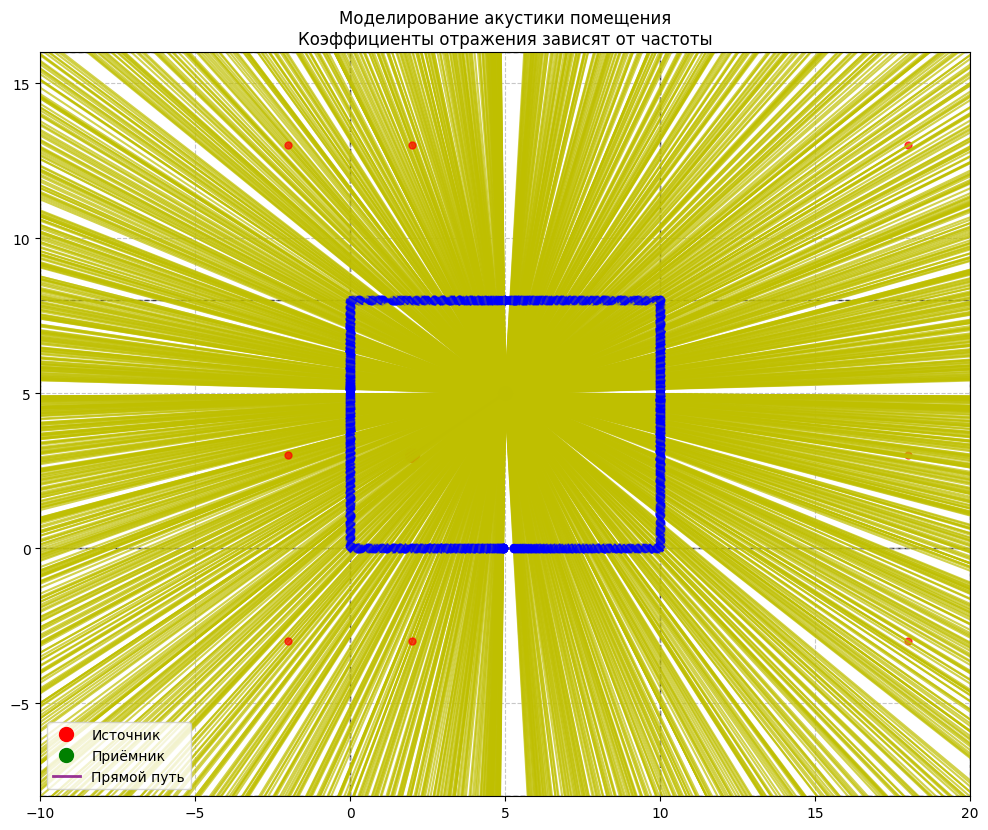


Параметр аппроксимации для 125 Гц E(r) = C / r^2: C = 0.0000


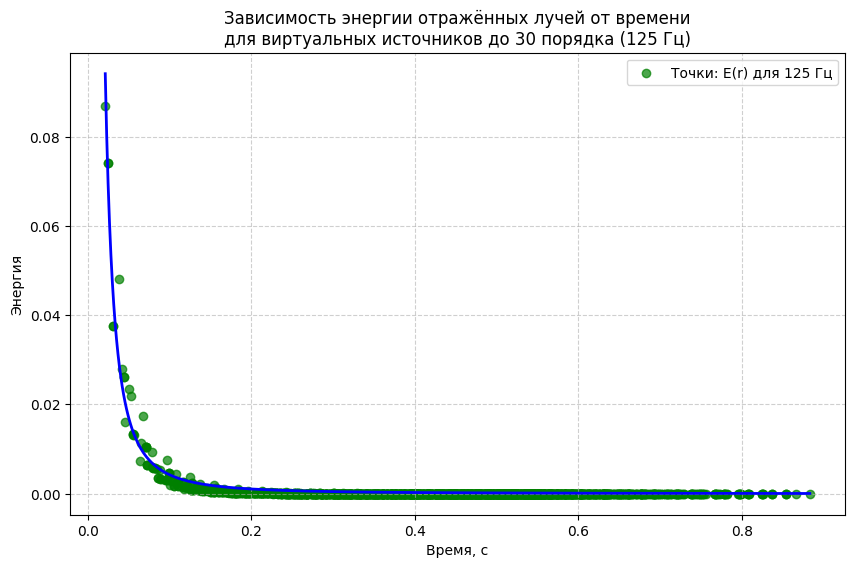


RT60 для 125 Гц: 0.463 секунд
Склон затухания: -129.569 дБ/сек
Коэффициент детерминации R²: 0.916


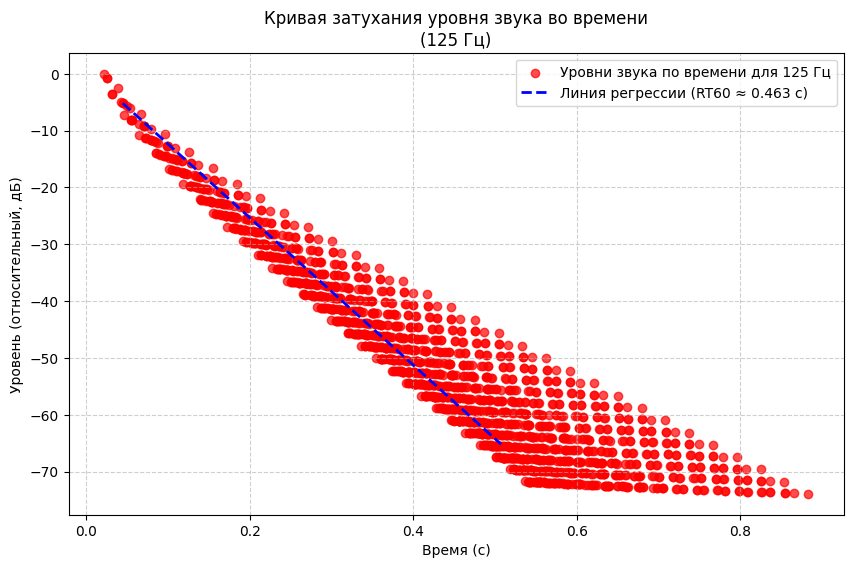


Параметр аппроксимации для 250 Гц E(r) = C / r^2: C = 0.0001


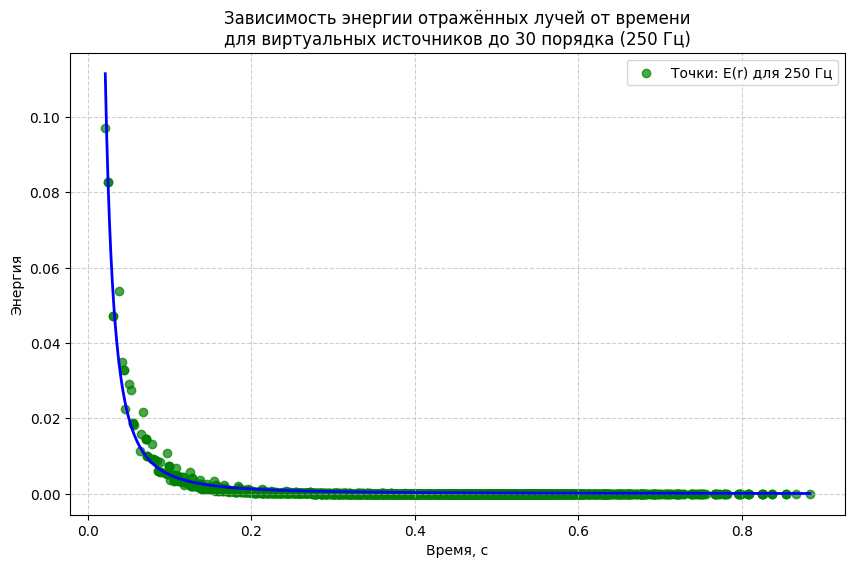


RT60 для 250 Гц: 0.593 секунд
Склон затухания: -101.133 дБ/сек
Коэффициент детерминации R²: 0.923


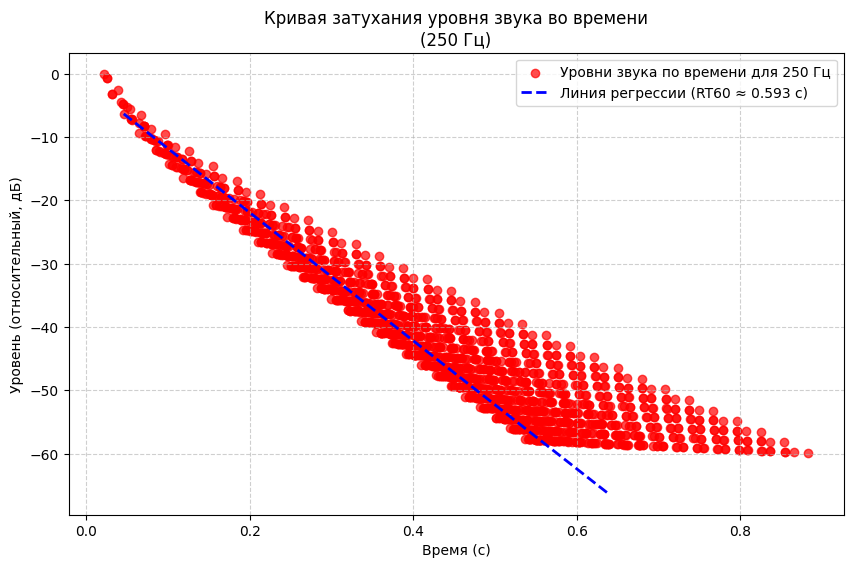


Параметр аппроксимации для 500 Гц E(r) = C / r^2: C = 0.0001


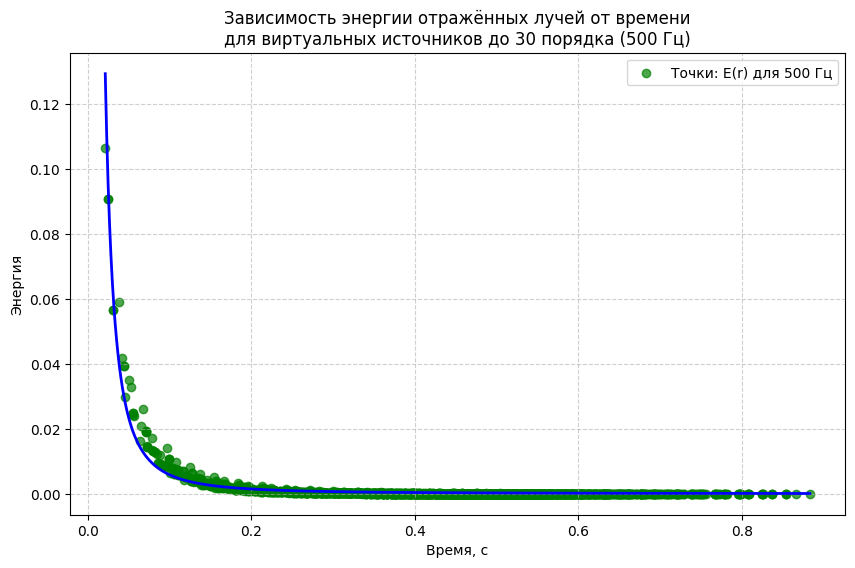


RT60 для 500 Гц: 0.783 секунд
Склон затухания: -76.610 дБ/сек
Коэффициент детерминации R²: 0.934


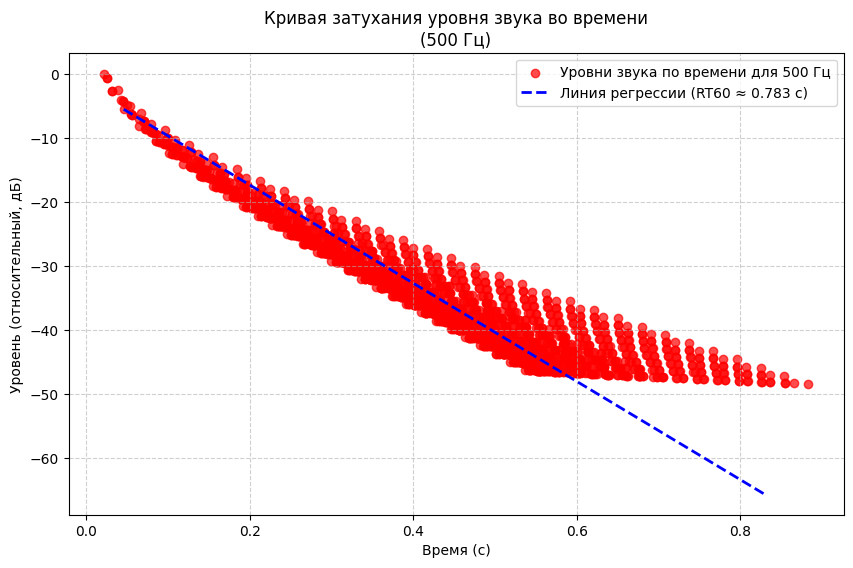


Параметр аппроксимации для 1 кГц E(r) = C / r^2: C = 0.0001


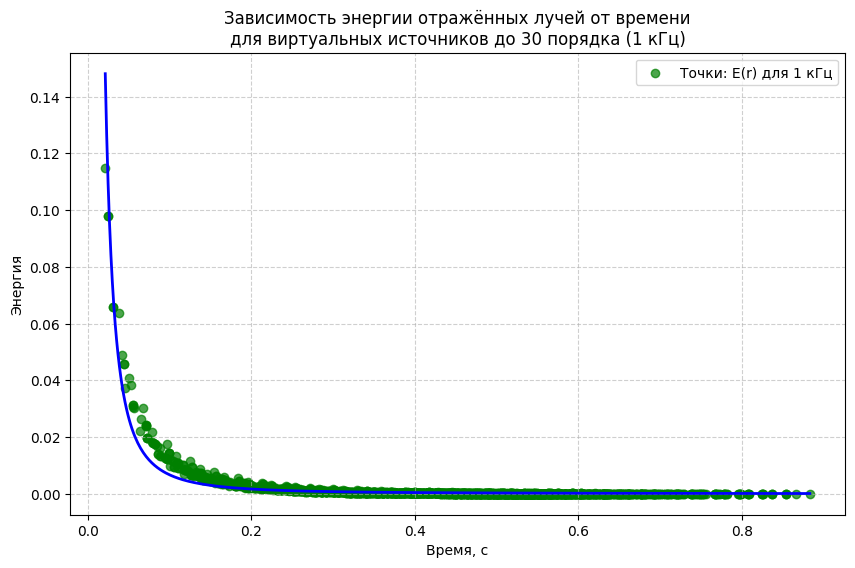


RT60 для 1 кГц: 1.079 секунд
Склон затухания: -55.606 дБ/сек
Коэффициент детерминации R²: 0.938


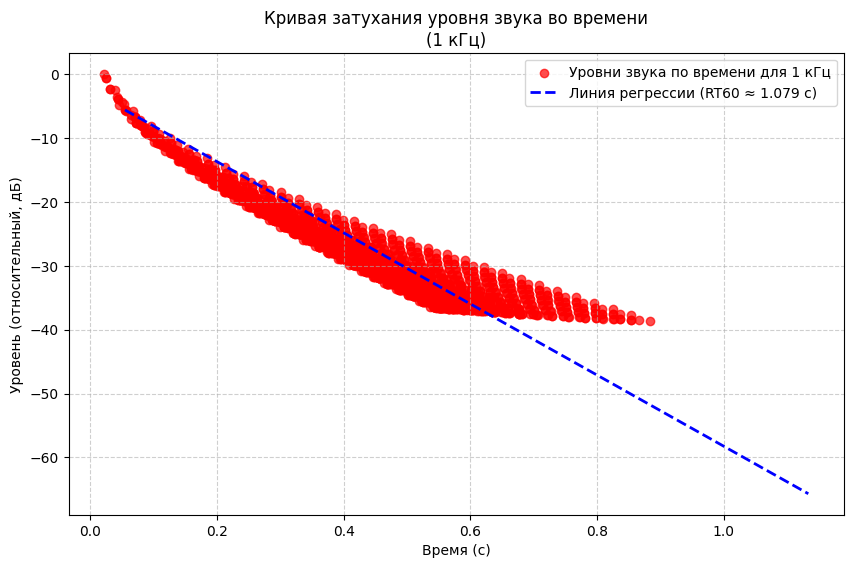


Параметр аппроксимации для 2 кГц E(r) = C / r^2: C = 0.0001


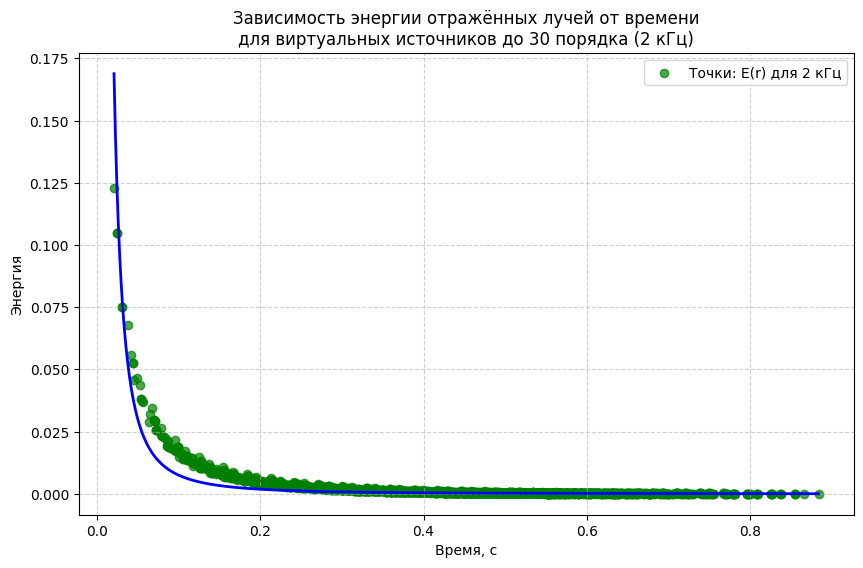


RT60 для 2 кГц: 1.672 секунд
Склон затухания: -35.883 дБ/сек
Коэффициент детерминации R²: 0.934


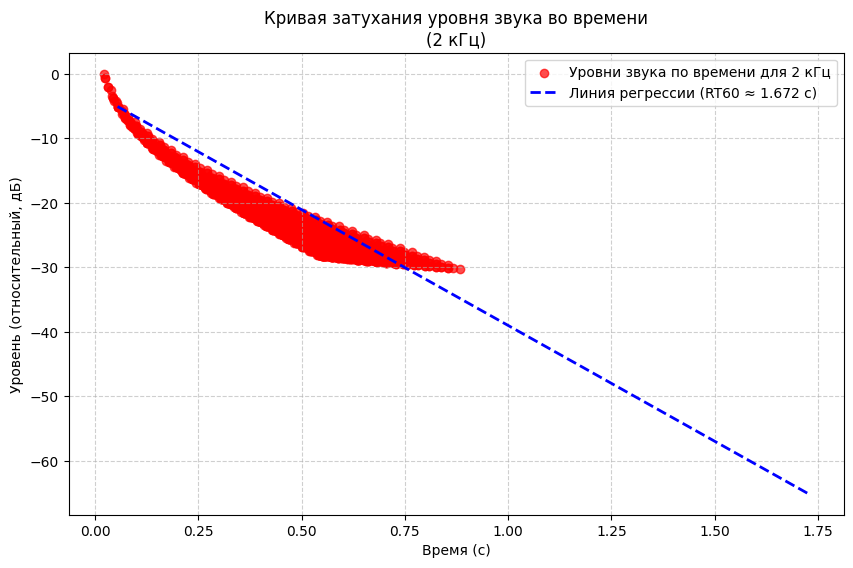


Параметр аппроксимации для 4 кГц E(r) = C / r^2: C = 0.0001


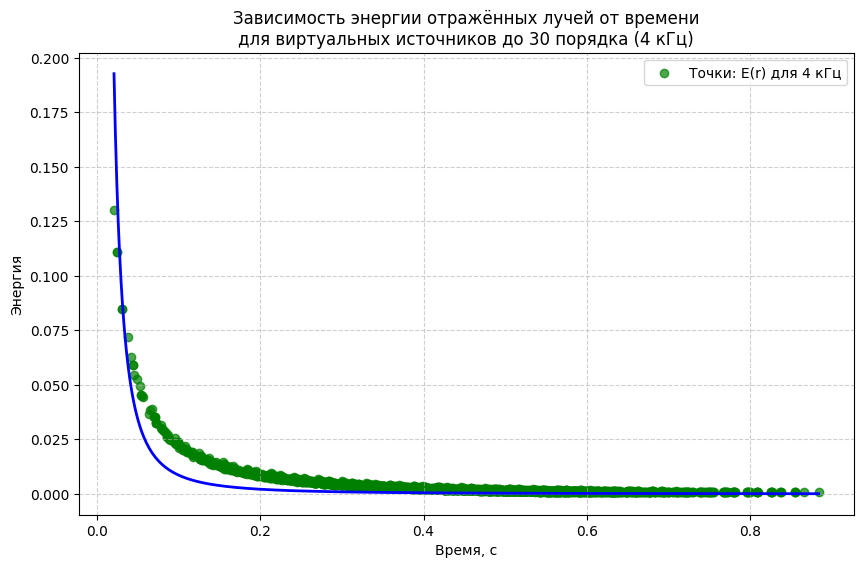


RT60 для 4 кГц: 2.876 секунд
Склон затухания: -20.859 дБ/сек
Коэффициент детерминации R²: 0.916


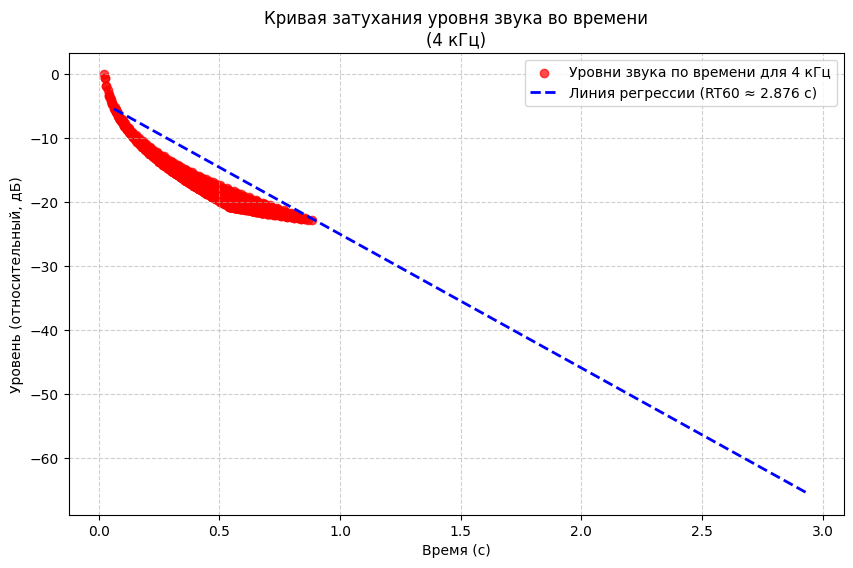

ТАБЛИЦА RT60 ДЛЯ ВСЕХ ЧАСТОТНЫХ ДИАПАЗОНОВ
Частота		RT60 (с)
-------------------------
125 Гц      	0.463
250 Гц      	0.593
500 Гц      	0.783
1 кГц       	1.079
2 кГц       	1.672
4 кГц       	2.876
[[np.float64(0.8834011678955452), np.float64(0.837059698565465), np.float64(0.8367550103688465), np.float64(0.837059698565465), np.float64(0.8267401177291644), np.float64(0.825402482869558), np.float64(0.8250934899404384), np.float64(0.825402482869558), np.float64(0.8260818604802653), np.float64(0.7815640863678756), np.float64(0.7801925765107413), np.float64(0.7787749950446965), np.float64(0.7784474942613203), np.float64(0.7787749950446965), np.float64(0.7794950124241801), np.float64(0.7815640863678756), np.float64(0.7731446417595405), np.float64(0.769949815523808), np.float64(0.7685575799948646), np.float64(0.7671184981682825), np.float64(0.766786018812825), np.float64(0.7671184981682825), np.float64(0.7678494459978901), np.float64(0.769949815523808), np.float64(0.771736142075059), np.fl

In [8]:
draw_room_and_sources(room_width, room_height, source, receiver, max_reflection_order, reflection_coeffs_freq)